In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

# ✅Нелинейные модели 

<b>Линейные модели</b> конечно хороши, но зачастую на практике интересующая нас зависимость описывается сложной нелинейной функцией. Как бы мы ни пытались приблизить ее прямой - ничего, кроме линейной зависимости на выходе мы не получим. Рассмотрим парочку нелинейных алгоритмов классического машинного обучени. Начнем с бинарного дерева принятия решений, а продолжим ансамблевым алгоритмом на его основе - градиентным бустингом над решающими деревьями. Про дерево <a href='https://habr.com/ru/companies/ods/articles/322534/'>тут</a>, а про бустинг - <a href='https://habr.com/ru/companies/ods/articles/327250/'>тут</a>.<br>
<b>ЗАМЕЧАНИЕ</b><br>
Статьи весьма объемные и рекомендуются к изучению только в случае, если есть желание углубиться. Для работы над проектом достаточно будет данного ноутбука.

Мы же пока подготовим данные для задачи классификации.

In [2]:
dataset = pd.read_csv('Titanic-Dataset.csv')
dataset.drop(['Name', 'PassengerId', 'Ticket', 'Cabin'], axis=1, inplace=True)
dataset.fillna(-1, inplace=True)

dataset_coded = dataset.copy()

dataset_coded['Sex'] = np.where(dataset_coded['Sex'] == 'male', 1, 0)

cat_features = dataset_coded.drop(['Sex'], axis=1).select_dtypes(include=['object'])
cat_columns = list(cat_features.columns)
dataset_coded.drop(cat_columns, axis=1, inplace=True)
cat_features.replace(-1, '-1', inplace=True)

ohe = OneHotEncoder()
ohe.fit(cat_features)
coded_cat_features = pd.DataFrame(ohe.transform(cat_features).toarray(), columns=ohe.get_feature_names_out())

dataset_coded = pd.concat([dataset_coded, coded_cat_features], axis=1)

standard_scaler = StandardScaler()
standard_scaler.fit(dataset_coded.drop(['Survived'], axis=1))
dataset_coded = pd.DataFrame(standard_scaler.transform(dataset_coded.drop(['Survived'], axis=1)), columns=standard_scaler.get_feature_names_out())

dataset_coded = pd.concat([dataset_coded, dataset['Survived']], axis=1)

# ✅Посмотрим на распределение классов

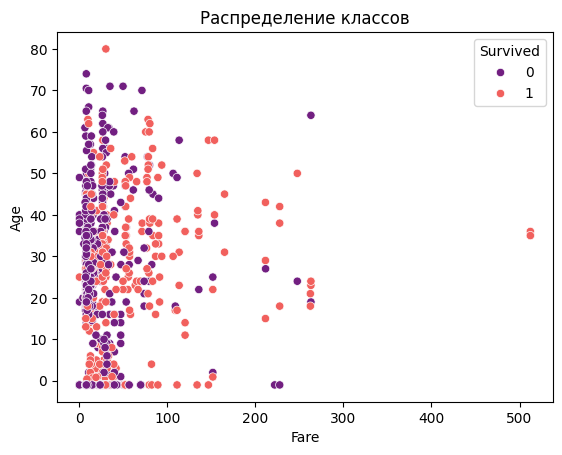

In [3]:
plot_classes = dataset[['Age', 'Fare', 'Survived']]
sns.scatterplot(data=plot_classes, x=plot_classes['Fare'], y=plot_classes['Age'], hue=plot_classes['Survived'], palette='magma')
plt.title('Распределение классов')
plt.show()

# ✅Разобьем данные на выборки

In [4]:
target = dataset['Survived']
X_train, X_test, y_train, y_test = train_test_split(dataset_coded.drop(['Survived'], axis=1), target, test_size=0.3, random_state=12)

# ✅Построим модели и сравним их качество

In [5]:
def plot_decision_boundary(model, X, y, f1, f2):
    
    X = X.copy()
    f1_name, f2_name = f1, f2
    f1, f2 = np.meshgrid(
    np.linspace(X[f1].min() - 1, X[f1].max() + 1),
    np.linspace(X[f2].min() - 1, X[f2].max() + 1)
    )
    
    model.fit(X[[f1_name, f2_name]], y)
    
    grid = np.vstack([f1.ravel(), f2.ravel()]).T
    y_pred = np.reshape(model.predict(grid), f1.shape)
    display = DecisionBoundaryDisplay(xx0=f1, xx1=f2, response=y_pred)
    display.plot()
    X.insert(2, column='target', value=y)
    sns.scatterplot(data=X, x=X[f1_name], y=X[f2_name], hue=X['target'], palette='magma')
    plt.show()

In [6]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [7]:
boosting = GradientBoostingClassifier(verbose=False)
boosting.fit(X_train, y_train)

GradientBoostingClassifier(verbose=False)

In [8]:
tree_train = accuracy_score(y_train, tree.predict(X_train))
tree_test = accuracy_score(y_test, tree.predict(X_test))
boost_train = accuracy_score(y_train, boosting.predict(X_train))
boost_test = accuracy_score(y_test, boosting.predict(X_test))

print('Результаты:')

pd.DataFrame(
    [[tree_train, tree_test], [boost_train, boost_test]],
    columns=['Train', 'Test'],
    index=['Tree', 'Boosting']
)

Результаты:


,Train,Test
Tree,0.983949,0.731343
Boosting,0.918138,0.809701


✅Обратите внимание на метрики и графики - что можно по ним сказать? Что это означает?

Сначала посмотрим на дерево:

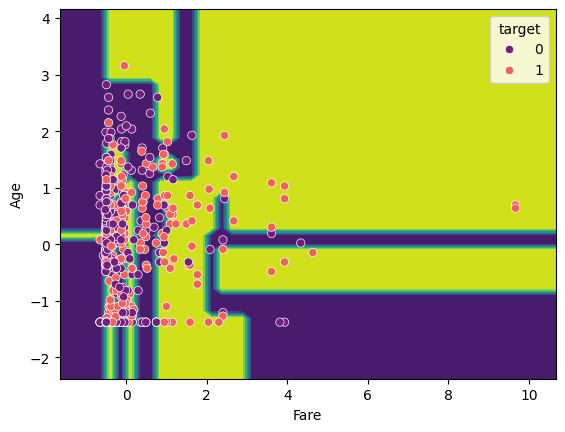

In [9]:
plot_decision_boundary(tree, X_train, y_train, 'Fare', 'Age')

А теперь и на бустинг:

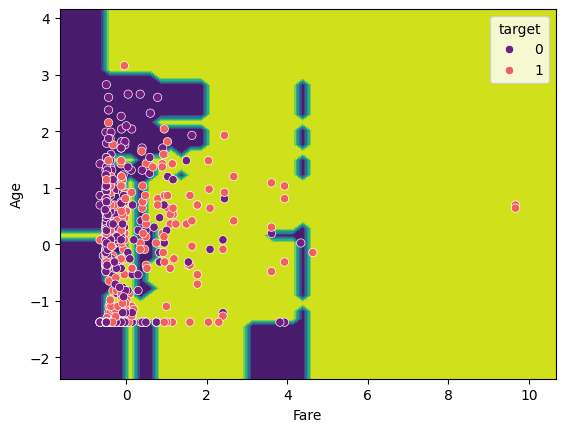

In [10]:
plot_decision_boundary(boosting, X_train, y_train, 'Fare', 'Age')